# Fudan RPML Assignment1: Machine Learning Meets Fashion

![Machine Learning Meets Fashion](./img/ml_meets_fashion.jpg)

*Your name and Student ID: [Name], [Student ID]*

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.*

In this assignment, you will use what you have learned to tackle some pratical problems. Fashion MNIST dataset[1] is the MNIST-like fashion product database for image classification you will play with this time. It originally consists of a training set of 60000 examples and a test set of 10000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. 

To make this task more realistic, we selected 14600 labeled examples from the training set and did a little processing. You have to do this image classifictaion task with our new dataset. 

You have to impletement several standard classification methods in the './fudanPRML' folder:
- K-nearest Neighbor (15 points)
- Softmax (15 points)
- Neural Network (30 points)    

and then do your exploration (30 points).

You can only use some basic python libraries in your experiment like numpy, paddle(without using the paddle.nn), matplotlib and so on. And please write down the version with them in the './requirements.txt' file.

## 1. Setup

In [1]:
# setup code
%load_ext autoreload
%autoreload 2
# 当导入了自己写的python模块时，在ipynb文件里import一次之后，即使修改了的python模块，重新运行import其实还是用的之前的python模块
# 因为已经将该模块在第一次导入时存在了内存里，第二次import没效果，这时需要重启kenel才能导入修改过的python模块。
# 此处首先自动加载导入的python模块，保证你每次在ipynb里使用的模块是最新版本，所以在你修改了模块代码之后，不需要重新刷新你的kenel。


In [2]:
import paddle

paddle.device.get_device()
paddle.set_device(paddle.device.get_device())

Place(cpu)

In [3]:
import numpy as np
dataset_path = './dataset'

X_train = np.load(dataset_path + '/X_train.npy')
y_train = np.load(dataset_path + '/y_train.npy')
X_test = np.load(dataset_path + '/X_test.npy')
y_test = np.load(dataset_path + '/y_test.npy')

In [4]:
label_name = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

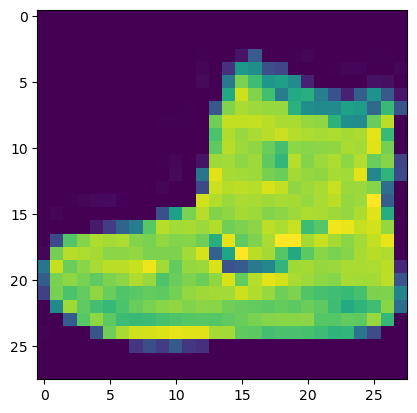

In [5]:
%matplotlib inline
# 可以将matplotlib的图表直接嵌入到Notebook之中，或者使用指定的界面库显示图表
from matplotlib import pyplot as plt

plt.imshow(X_train[0].reshape(28,28))

## 2. Exploratory Data Analysis (5 points)

Your may have to explore the dataset and do some analysis first.

训练集中各类别条目数量:
 [6000, 4000, 1000, 1000, 1000, 1000, 200, 200, 100, 100]
观察可知存在类别不均衡的问题


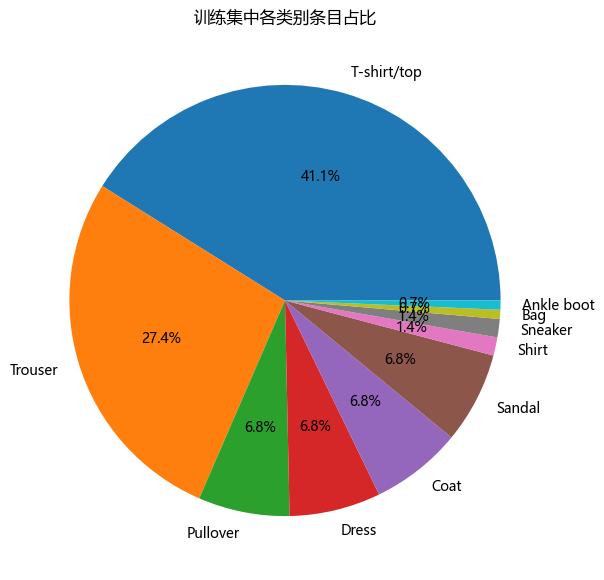

In [156]:
label_summary = [0 for i in range(10)]
for label in y_train:
    label_summary[label] = label_summary[label] + 1
print('训练集中各类别条目数量:\n',label_summary)
print('观察可知存在类别不均衡的问题')
plt.figure(figsize=(7,7))
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  #指定字体为雅黑，解决文字乱码问题
plt.title('训练集中各类别条目占比')
plt.pie(label_summary,labels=label_name,autopct="%1.1f%%")
plt.show()


## 3. Methodology

#### 导入自定义模块

In [7]:
# Please open the corresponding file and complete it first
# The codebase is organized in a sklearn style
# you have to finish the 'fit' and 'predict' function and do your experiment in this .ipynb file
from fudanPRML.neighbors.k_nearest_neighbor import KNearestNeighbor
from fudanPRML.linear_model.softmax import SoftmaxClassifier
from fudanPRML.neural_network.mlp import MLPClassifier

### 3.1 K-nearest Neighbor (15 points)

#### 实例化KNN分类器

In [73]:

clf = KNearestNeighbor()
clf.fit(X_train, y_train)
dists = clf.compute_distances_no_loops(X_test)
print(dists.shape)

(10000, 14600)


#### 进行5折交叉验证选择最优超参数k的值

In [74]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10]

X_train_folds = []
y_train_folds = []
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
k_to_accuracies = {}
for k in k_choices:
    acc = []
    for i in range(num_folds):
        X_val_train = np.vstack(X_train_folds[0:i] + X_train_folds[i+1:])
        y_val_train = np.hstack(y_train_folds[0:i] + y_train_folds[i+1:])
        clf.fit(X_val_train,y_val_train)
        y_pred = clf.predict(X_train_folds[i], k)
        num_correct = np.sum(y_pred == y_train_folds[i])
        accuracy = float(num_correct) / len(y_train_folds[i])
        acc.append(accuracy)
        k_to_accuracies[k] = acc


# 打印出计算的精度
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy),end = '\t')
    print()
    


k = 1, accuracy = 0.129795	k = 1, accuracy = 0.164384	k = 1, accuracy = 0.048288	k = 1, accuracy = 0.000000	k = 1, accuracy = 0.000000	
k = 3, accuracy = 0.129795	k = 3, accuracy = 0.164384	k = 3, accuracy = 0.048288	k = 3, accuracy = 0.000000	k = 3, accuracy = 0.000000	
k = 5, accuracy = 0.129795	k = 5, accuracy = 0.164384	k = 5, accuracy = 0.048288	k = 5, accuracy = 0.000000	k = 5, accuracy = 0.000000	
k = 8, accuracy = 0.129795	k = 8, accuracy = 0.164384	k = 8, accuracy = 0.048288	k = 8, accuracy = 0.000000	k = 8, accuracy = 0.000000	
k = 10, accuracy = 0.129795	k = 10, accuracy = 0.164384	k = 10, accuracy = 0.048288	k = 10, accuracy = 0.000000	k = 10, accuracy = 0.000000	


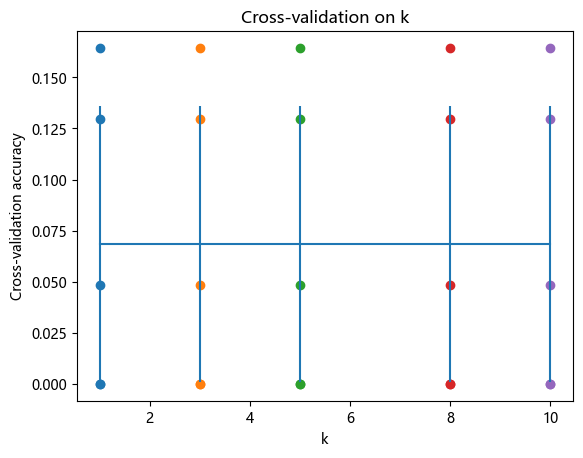

In [75]:
# 绘制原始观察结果
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# 用与标准偏差相对应的误差线绘制趋势线
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

#### 选择最佳k值，使用全部训练数据训练分类器并测试

In [76]:
# 根据上述交叉验证结果，为k选择最佳值，使用所有训练数据重新训练分类器，
# 并在测试中对其进行测试数据。
best_k = k_choices[accuracies_mean.argmax()]
print('best_k = ',best_k)
clf = KNearestNeighbor()
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test_pred)
print('Got %d / %d correct => accuracy: %f' % (num_correct, len(y_test_pred), accuracy))

best_k =  1
Got 1000 / 10000 correct => accuracy: 0.100000


### 3.2 Softmax (15 points)

#### 处理数据集，从训练集再次划分出验证集，用于最优模型保存

In [8]:
# 将训练数据打乱，并进一步划分为训练和验证两部分

# 固定随机数种子
paddle.seed(1024)
is_shuffle = True

if is_shuffle:
    idx = paddle.randperm(X_train.shape[0])
    X_train = X_train[idx]
    y_train = y_train[idx]
    
# 验证集比例
valid_rate = 0.2

data_num = X_train.shape[0]
train_num = int(data_num*(1 - valid_rate))

# 训练数据类型是uint8，但是paddle居然不支持! 这里分别转为float32和int32
X_train_set = paddle.to_tensor(X_train[:train_num],dtype='float32') 
X_valid_set = paddle.to_tensor(X_train[train_num:],dtype='float32')
y_train_set = paddle.to_tensor(y_train[:train_num],dtype='int32')   
y_valid_set = paddle.to_tensor(y_train[train_num:],dtype='int32')
X_test_set = paddle.to_tensor(X_test,dtype = 'float32')
y_test_set = paddle.to_tensor(y_test,dtype = 'int32')

#### 定义模型、损失函数、优化器、评价指标、封装好的用于训练测试的Runner类

In [9]:
from fudanPRML.linear_model.softmax import SoftmaxClassifier
from fudanPRML.linear_model.criterion import MultiCrossEntropyLoss
from fudanPRML.linear_model.optimizer import SimpleBatchGD
from fudanPRML.linear_model.metric import accuracy
from fudanPRML.linear_model.runner import RunnerV2


#### 定义绘图函数

In [10]:
def plot(runner,fig_name):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    epochs = [i for i in range(len(runner.train_scores))]
    # 绘制训练损失变化曲线
    plt.plot(epochs, runner.train_loss, color='#e4007f', label="Train loss")
    # 绘制评价损失变化曲线
    plt.plot(epochs, runner.dev_loss, color='#f19ec2', linestyle='--', label="valid loss")
    # 绘制坐标轴和图例
    plt.ylabel("loss", fontsize='large')
    plt.xlabel("epoch", fontsize='large')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.subplot(1,2,2)
    # 绘制训练准确率变化曲线
    plt.plot(epochs, runner.train_scores, color='#e4007f', label="Train accuracy")
    # 绘制评价准确率变化曲线
    plt.plot(epochs, runner.dev_scores, color='#f19ec2', linestyle='--', label="valid accuracy")
    # 绘制坐标轴和图例
    plt.ylabel("score", fontsize='large')
    plt.xlabel("epoch", fontsize='large')
    plt.legend(loc='lower right', fontsize='x-large')
    plt.tight_layout()
    plt.savefig(fig_name)
    plt.show()

#### 设置参数，实例化模型

In [11]:
init_lr = 0.05
num_epochs = 100
log_epochs = 10

model = SoftmaxClassifier(input_dim = 784 ,output_dim = 10)
metric = accuracy
criterion = MultiCrossEntropyLoss()
optimizer = SimpleBatchGD(init_lr=init_lr,model=model)
# 实例化RunnerV2
runner = RunnerV2(model, optimizer, metric, criterion)

#### 启动训练

In [13]:
runner.train([X_train_set, y_train_set], [X_valid_set, y_valid_set], num_epochs = num_epochs, log_epochs = log_epochs, save_path="best_model.pdparams")

best accuracy performence has been updated: 0.00000 --> 0.41062
[Train] epoch: 0, loss: 2.302705764770508, score: 0.41104450821876526
[Dev] epoch: 0, loss: 52.292354583740234, score: 0.4106164276599884
best accuracy performence has been updated: 0.41062 --> 0.71199
best accuracy performence has been updated: 0.71199 --> 0.75205
best accuracy performence has been updated: 0.75205 --> 0.76952
[Train] epoch: 10, loss: 35.838523864746094, score: 0.5952054858207703
[Dev] epoch: 10, loss: 20.34522247314453, score: 0.7695205211639404
best accuracy performence has been updated: 0.76952 --> 0.80548
best accuracy performence has been updated: 0.80548 --> 0.82740
[Train] epoch: 20, loss: 17.085304260253906, score: 0.8070205450057983
[Dev] epoch: 20, loss: 17.761268615722656, score: 0.7989726066589355
best accuracy performence has been updated: 0.82740 --> 0.82808
best accuracy performence has been updated: 0.82808 --> 0.83185
[Train] epoch: 30, loss: 16.36480712890625, score: 0.814811646938324
[D

#### 绘制图像

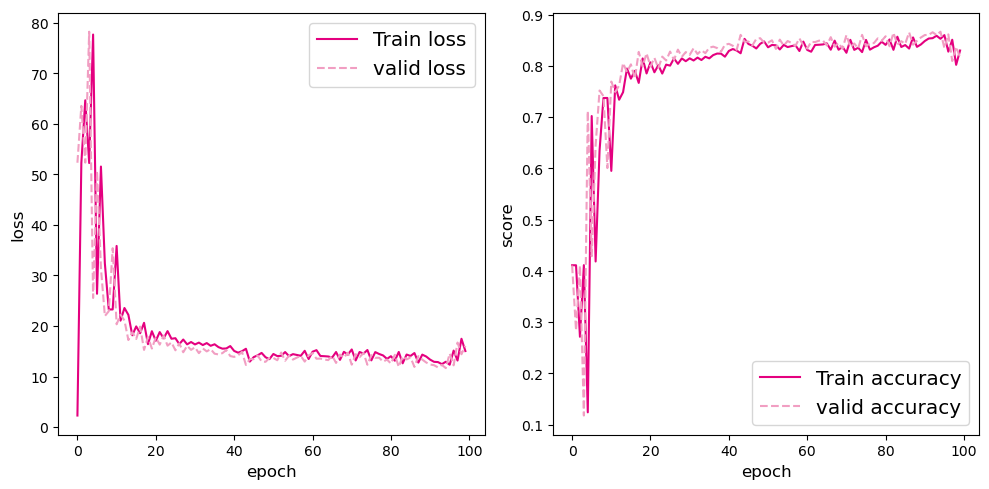

In [14]:
# 绘制训练过程中loss下降图像

plot(runner,fig_name='softmax_classifier.pdf')

#### 在测试集上评估模型

In [15]:
# 使用测试集评估模型

# 加载最优模型
runner.load_model('best_model.pdparams')
# 模型评价
score, loss = runner.evaluate([X_test_set, y_test_set])
print(f'[Test Dataset]: accuracy:{score}, loss: {loss}')

[Test Dataset]: accuracy:0.5853000283241272, loss: 36.521820068359375


#### 一些感受与分析


##### 关于使用验证集的问题：

类别不均衡问题仍然影响很大，在测试集上效果相当不好，使用验证集保存最优参数的方法，事实上也逐渐使得模型拟合在了验证集上

然而，我们应该注意到，本身测试集类别不均衡，验证集中更可能出现某些类别数量极其小的情况，因此反而效果更差。

##### 关于优化器和梯度下降过程：

一开始使用了lr = 0.1 的整批常规梯度下降方法，在训练到接近100轮epoch时，loss出现激增。分析原因，应该是在训练后期学习率过大所致，后续可以采用学习率衰减的方法

### 3.3 Neural Network (30 points)

### Your Exploration (30 points)

## 4. Conclusion (5 points)

## Reference
List your references here.

[1] Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv: https://arxiv.org/abs/1708.07747, GitHub: https://github.com/zalandoresearch/fashion-mnist